## Part 3 Question 4

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pylab as pl
import datetime as dt

import math
import scipy.stats as scs
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

import time
import matplotlib.ticker as mticker

In [2]:
from pickle import FALSE
import numpy as np

def CRROptionWGreeks(currStockPrice, strikePrice, intRate, divYield, vol, totSteps, yearsToExp, optionType, american):
    """ BinomialOptionPricer implements a simple binomial model for option pricing
    
        currStockPrice = Current price of the underlying stock
        strikePrice = Strike price of the option
        intRate = Annualized continuous compounding interest rate
        divYield = Annualized continuous compounding dividend yield
        vol = Expected forward annualized stock price volatility
        totStep = Depth of the tree model
        yearsToExp = Time to expiry in years
        optionType = "CALL" or "PUT"
        american = true or false, i.e. is early excercise allowed (true = American option, false = European)
    
        returns the calculated price of the option
    """

    # calculate the number of time steps that we require
    timeStep = yearsToExp / totSteps
      
    # one step random walk (price increases)
    u = np.exp(vol * np.sqrt(timeStep))
    # one step random walk (price decreases)
    d = np.exp(-vol * np.sqrt(timeStep))

    # risk neutral probability of an up move
    pu = (np.exp((intRate - divYield) * timeStep) - d) / (u - d)
    # risk neutral probability of a down move
    pd = 1 - pu

    # Tree is evaluated in two passes
    # In the first pass the probability weighted value of the stock price is calculated at each node
    # In the second pass the value of the option is calculated for each node given the stock price, backwards from the final time step
    # Note that the tree is recombinant, i.e. u+d = d+u

    # First we need an empty matrix big enough to hold all the calculated prices
    priceTree = np.full((totSteps, totSteps), np.nan) # matrix filled with NaN == missing values
    # Note that this tree is approx twice as big as needed because we only need one side of diagonal
    # We use the top diagonal for efficiency

    # Initialize with the current stock price, then loop through all the steps
    priceTree[0, 0] = currStockPrice

    for ii in range(1, totSteps):
        # vector calculation of all the up steps (show how the indexing works on line)
        priceTree[0:ii, ii] = priceTree[0:ii, (ii-1)] * u

        # The diagonal will hold the series of realizations that is always down
        # this is a scalar calculation
        priceTree[ii, ii] = priceTree[(ii-1), (ii-1)] * d

        # print("\n", priceTree)

    # Now we can calculate the value of the option at each node
    # We need a matrix to hold the option values that is the same size as the price tree
    # Note that size returns a vector of dimensions [r, c] which is why it can be passed as dimensions to nan
    optionValueTree = np.full_like(priceTree, np.nan)

    # First we calculate the terminal value
    if optionType == "CALL":
        optionValueTree[:, -1] = np.maximum(0, priceTree[:, -1] - strikePrice)
        # note the handy matrix shortcut syntax & max applied elementwise
    elif optionType == "PUT":
        optionValueTree[:, -1] = np.maximum(0, strikePrice - priceTree[:, -1])
    else:
        # wherever possible, check that the input parameters are valid and raise an exception if not
        raise ValueError("Only CALL and PUT option types are supported")

    # print("\n", optionValueTree)

    oneStepDiscount = np.exp(-intRate * timeStep)    # discount rate for one step

    # Now we step backwards to calculate the probability weighted option value at every previous node
    # How many backwards steps?
    backSteps = priceTree.shape[1] - 1  # notice the shape function -> 1 is # of columns, which is last index + 1

    for ii in range(backSteps, 0, -1):
        optionValueTree[0:ii, ii-1] = \
            oneStepDiscount * \
            (pu * optionValueTree[0:ii, ii] \
            + pd * optionValueTree[1:(ii+1), ii])

        #if the option is american then you can convert at anytime, so the option value can never be less than the intrinsic value
        if american:
            if optionType == "CALL":
                optionValueTree[0:ii, ii] = np.maximum(priceTree[0:ii, ii] - strikePrice, optionValueTree[0:ii, ii])
            else:
                optionValueTree[0:ii, ii] = np.maximum(strikePrice - priceTree[0:ii, ii], optionValueTree[0:ii, ii])

        # print("\n", optionValueTree)

    # After all that, the current price of the option will be in the first element of the optionValueTree
    optionPrice = optionValueTree[0, 0]

    # Delta is the difference between the up and down option prices at the first branch, divided by the price change
    # Note that time is not held constant in this way
    # the more steps the more closely the estimate will match "instantaneous"

    def D(x, y):
        d = (optionValueTree[x, y + 1] - optionValueTree[x + 1, y + 1]) / (priceTree[x, y + 1] - priceTree[x + 1, y + 1]);
        return d

    delta = D(0,0)

    gamma = (D(0,1) - D(1,1)) / (0.5 * (priceTree[0,2] - priceTree[2, 2]))

    # Note that theta is measured in the underlying units of timeStep, typically years
    theta = (optionValueTree[1, 2] - optionValueTree[0, 0]) / (2 * timeStep)
    theta = theta / 365

    return optionPrice, delta, gamma, theta     # this return type is a "tuple" - a list of related data


In [3]:
# Collecting data and calculating time
A_price = []
time_calc = []
steps = range(20,500,20)
for step in steps:
    start = time.time_ns()
    A_price.append(CRROptionWGreeks(100, 100, 0.02, 0, 0.2, step, 1, "CALL", True))
    end = time.time_ns()
    time_calc.append(end-start)

### Answer for Question 4

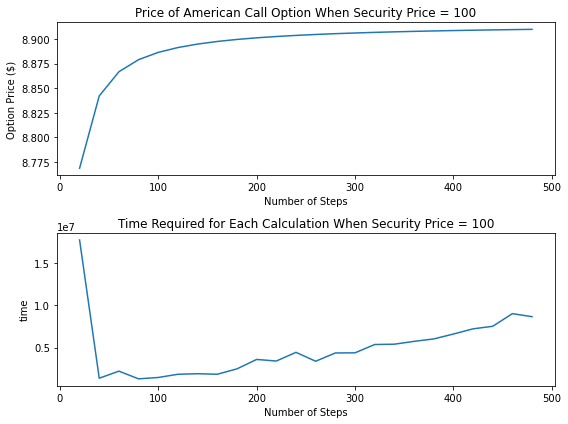

In [4]:
# Plotting price and time of american call option when security price is $100
AP = pd.DataFrame(A_price)
AP.columns = ['Price','Delta','Gamma','Tetha']


fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))

ax1.plot(steps, AP['Price'])
ax1.set_title('Price of American Call Option When Security Price = 100')
ax1.set_ylabel('Option Price ($)')
ax1.set_xlabel('Number of Steps')

ax2.plot(steps, time_calc)
ax2.set_title('Time Required for Each Calculation When Security Price = 100')
ax2.set_ylabel('time')
ax2.set_xlabel('Number of Steps')

plt.tight_layout()
plt.show()

In [5]:
#Converting steps to dataframe
steps_100 = pd.DataFrame(steps)

In [6]:
# Finding steps when price difference is within $0.01
steps_100.rename(columns={0:"steps"}, inplace=True)
AP_steps = pd.merge(AP,steps_100, left_index=True, right_index=True)
AP_steps['diff100'] = AP['Price'] - AP['Price'].shift(1)
AP_steps[AP_steps['diff100']<0.01].head()

,Price,Delta,Gamma,Tetha,steps,diff100
4,8.886447,0.578670,0.019707,-0.013484,100,0.007390
5,8.891375,0.578769,0.019681,-0.013470,120,0.004928
6,8.894896,0.578839,0.019662,-0.013460,140,0.003521
7,8.897537,0.578892,0.019648,-0.013452,160,0.002641
8,8.899592,0.578933,0.019638,-0.013446,180,0.002055


### Answer:

### When security price is 100, it requires around 100 steps before the calculated price converges to within &#36; 0.01

In [7]:
A_price = []
time_calc = []
steps = range(20,500,20)
for step in steps:
    start = time.time_ns()
    A_price.append(CRROptionWGreeks(105, 100, 0.02, 0, 0.2, step, 1, "CALL", True))
    end = time.time_ns()
    time_calc.append(end-start)

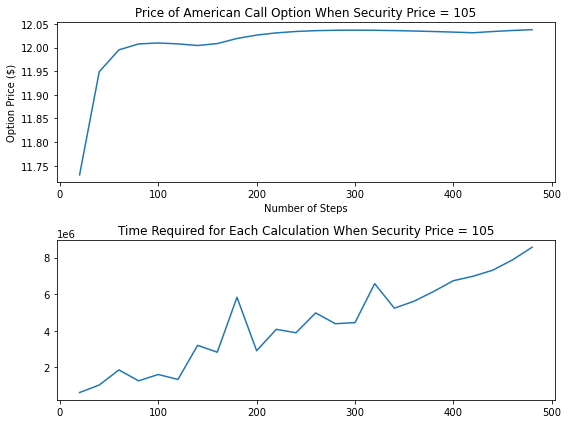

In [8]:
# Plotting price and time of american call option when security price is $105
AP = pd.DataFrame(A_price)
AP.columns = ['Price','Delta','Gamma','Tetha']

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))

ax1.plot(steps, AP['Price'])
ax1.set_title('Price of American Call Option When Security Price = 105')
ax1.set_ylabel('Option Price ($)')
ax1.set_xlabel('Number of Steps')

ax2.plot(steps, time_calc)
ax2.set_title('Time Required for Each Calculation When Security Price = 105')

plt.tight_layout()
plt.show()

In [9]:
#Converting steps to dataframe
steps_105 = pd.DataFrame(steps)

In [10]:
# Finding steps when price difference is within $0.01
steps_105.rename(columns={0:"steps"}, inplace=True)
AP_steps = pd.merge(AP,steps_105, left_index=True, right_index=True)
AP_steps['diff105'] = AP['Price'] - AP['Price'].shift(1)
AP_steps[AP_steps['diff105']<0.01].head()

,Price,Delta,Gamma,Tetha,steps,diff105
4,12.009680,0.671416,0.017363,-0.013696,100,0.002038
5,12.007784,0.671519,0.017355,-0.013692,120,-0.001896
6,12.004310,0.671603,0.017354,-0.013692,140,-0.003474
7,12.008403,0.671579,0.017340,-0.013682,160,0.004093
9,12.026356,0.671428,0.017294,-0.013653,200,0.007150


### Answer:

### When security price is 105, it requires around 100 steps before the calculated price converges to within &#36; 0.01